In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
quotations = pd.read_csv("../quotations231001.csv").drop(columns='sys_cooler')
print('len:', len(quotations))
quotations.head()

len: 1080


,cpu,mainboard,ram,gpu,case,power,cooler,ssd
0,18640280.0,18652877.0,16443341.0,27613427.0,21583046.0,19813847.0,21550985.0,12338942.0
1,18039569.0,18652877.0,18700841.0,18021914.0,18419840.0,19023932.0,NaN,13538642.0
2,19627808.0,18021440.0,18911780.0,18668606.0,12969350.0,21206702.0,18714860.0,17454683.0
3,19174175.0,21628184.0,18911780.0,21629063.0,NaN,19814027.0,NaN,17001050.0
4,17913710.0,18021491.0,18911780.0,18303401.0,16571885.0,18442058.0,18076145.0,16587443.0


In [3]:
cpus = quotations.cpu

In [4]:
cpu_df = pd.read_csv("../part_cpu_wb230922.csv")
mainboard_df = pd.read_csv("../part_mainboard230926.csv")
ram_df = pd.read_csv("../part_ram230921.csv")
gpu_df = pd.read_csv("../part_gpu_wb230921.csv")
case_df = pd.read_csv("../part_case230920.csv")
power_df = pd.read_csv("../part_power230920.csv")
cooler_df = pd.read_csv("../part_cooler230920.csv")
ssd_df = pd.read_csv("../part_ssd230926.csv")

In [8]:
prices_r = dict({'cpu': [], 'gpu': [], 'ram': []})
prices = dict({'cpu': [], 'gpu': [], 'ram': [], 'total': []})
pseqs = dict({'cpu': [], 'gpu': [], 'ram': []})

for row in quotations.values:
    try:
        cpu_price = cpu_df.loc[cpu_df['product_seq'] == row[0], 'price'].iloc[0]
        ram_price = ram_df.loc[ram_df['product_seq'] == row[2], 'price'].iloc[0]
        gpu_price = gpu_df.loc[gpu_df['product_seq'] == row[3], 'price'].iloc[0]

        others = []
        others.append(mainboard_df.loc[mainboard_df['product_seq'] == row[1], 'price'])
        others.append(case_df.loc[case_df['product_seq'] == row[4], 'price'])
        others.append(power_df.loc[power_df['product_seq'] == row[5], 'price'])
        others.append(cooler_df.loc[cooler_df['product_seq'] == row[6], 'price'])
        others.append(ssd_df.loc[ssd_df['product_seq'] == row[7], 'price'])
        
        total = cpu_price+gpu_price+ram_price
        for o in others:
            if not o.empty: total += o.iloc[0]
        if np.isnan(total) or np.isnan(gpu_price) or np.isnan(ram_price): continue
        prices_r['cpu'].append(cpu_price / total)
        prices_r['gpu'].append(gpu_price / total)
        prices_r['ram'].append(ram_price / total)
        
        prices['cpu'].append(cpu_price)
        prices['gpu'].append(gpu_price)
        prices['ram'].append(ram_price)
        prices['total'].append(total)
        
        pseqs['cpu'].append(cpu_df.loc[cpu_df['product_seq'] == row[0], 'product_seq'].iloc[0])
        pseqs['gpu'].append(gpu_df.loc[gpu_df['product_seq'] == row[2], 'product_seq'].iloc[0])
        pseqs['ram'].append(ram_df.loc[ram_df['product_seq'] == row[3], 'product_seq'].iloc[0])
        
    except Exception as e:
        continue

In [9]:
for key in prices_r.keys():
    print(len(prices_r[key]))
    print(len(prices[key]))
print(len(prices['total']))

680
680
680
680
680
680
680


In [10]:
minc = min(prices['cpu'])
maxc = max(prices['cpu'])
ming = min(prices['gpu'])
maxg = max(prices['gpu'])
minr = min(prices['ram'])
maxr = max(prices['ram'])
mint = min(prices['total'])
maxt = max(prices['total'])

In [11]:
cpn = [(x - minc) / (maxc - minc) for x in prices['cpu']]
gpn = [(x - ming) / (maxg - ming) for x in prices['gpu']]
rpn = [(x - minr) / (maxr - minr) for x in prices['ram']]
tpn = [(x - mint) / (maxt - mint) for x in prices['total']]

In [12]:
for t in prices['cpu']:
    if np.isnan(t):
        print(t)

In [13]:
pdata = np.array([cpn, gpn, rpn, tpn]).T

In [14]:
price_rate = np.array(pd.DataFrame(prices_r))

In [29]:
k = 6
model = KMeans(n_clusters=k, n_init='auto')

### CPU, GPU, RAM, 총 가격 수준이 비슷한 견적들끼리 묶는다.
- 군집화(Clustering)에 K-Means 알고리즘을 사용함

In [36]:
model.fit(pdata)

C:\Users\SSAFY\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=6, n_init='auto')

In [37]:
res = model.predict(pdata)

# 1. 총 견적 가격(y축)에서 CPU가 차지하는 비율(x축)
- 전체적으로 총 견적 가격이 높을수록 CPU의 가격이 차지하는 비율은 낮아짐
- 그룹1 (파랑): 일반적인 용도 (사무 등)
- 그룹2 (노랑): 중간 사양
- 그룹3 (초록): 고사양
- 그룹4 (빨강): 고사양(게임)

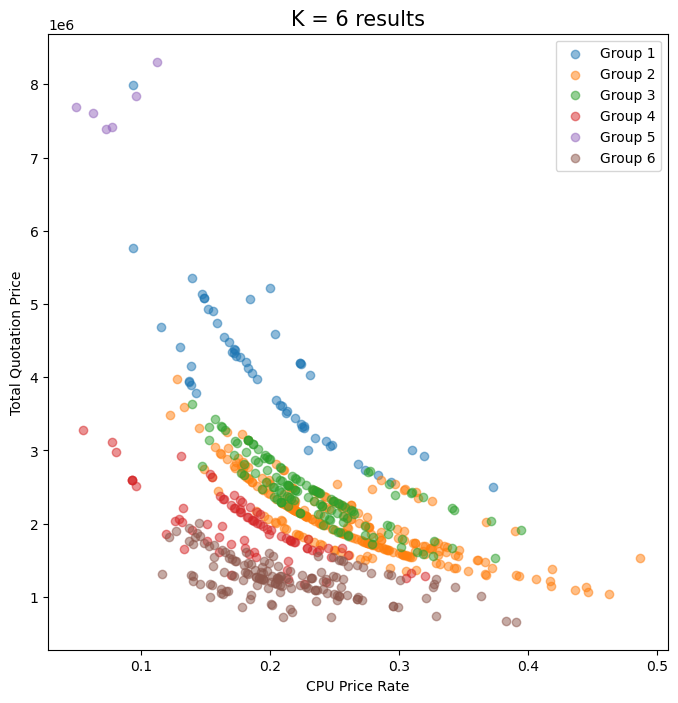

In [38]:
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(price_rate[res == i, 0], pdata[res == i, 3] * (maxt - mint) + mint, alpha=0.5, label=f'Group {i+1}')

plt.title('K = %d results'%k , size = 15)
plt.legend()
plt.xlabel('CPU Price Rate')
plt.ylabel('Total Quotation Price')
plt.show()

In [39]:
for i in range(k):
    cpu_bench = 0
    for cseq in np.array(pseqs['cpu'])[res == i]:
        cpu_bench += cpu_df.loc[cpu_df['product_seq'] == cseq, 'bench_mark'].iloc[0]
    group_len = len(np.array(pseqs['cpu'])[res == i])
    print(f'Group{i+1} Average Bench: {cpu_bench/group_len:.0f}')

Group1 Average Bench: 56889
Group2 Average Bench: 41670
Group3 Average Bench: 44132
Group4 Average Bench: 33729
Group5 Average Bench: 47083
Group6 Average Bench: 26903


In [40]:
for i in range(k):
    cpu_price = 0
    for cseq in np.array(pseqs['cpu'])[res == i]:
        cpu_price += cpu_df.loc[cpu_df['product_seq'] == cseq, 'price'].iloc[0]
    group_len = len(np.array(pseqs['cpu'])[res == i])
    print(f'Group{i+1} Average Price: {cpu_price/group_len:.0f}')

Group1 Average Price: 756804
Group2 Average Price: 506197
Group3 Average Price: 552512
Group4 Average Price: 343336
Group5 Average Price: 610965
Group6 Average Price: 261563


In [41]:
for i in range(k):
    cpu_rate = np.average(price_rate[res == i, 0]) * 100
    gpu_rate = np.average(price_rate[res == i, 1]) * 100
    ram_rate = np.average(price_rate[res == i, 2]) * 100
    print(f'Group{i+1} Average Rate: {cpu_rate:2.0f}%: {gpu_rate:2.0f}%: {ram_rate:1.0f}%: {np.sum([cpu_rate, gpu_rate, ram_rate]):2.0f}%')

Group1 Average Rate: 20%: 51%: 3%: 74%
Group2 Average Rate: 26%: 46%: 3%: 75%
Group3 Average Rate: 23%: 45%: 7%: 75%
Group4 Average Rate: 18%: 51%: 6%: 76%
Group5 Average Rate:  8%: 76%: 2%: 86%
Group6 Average Rate: 21%: 47%: 4%: 73%


# 2. 총 견적 가격(y축)에서 GPU가 차지하는 비율(x축)
- 전체적으로 총 견적 가격이 높을수록 GPU의 가격이 차지하는 비율은 높아짐
- 그룹1 (파랑)

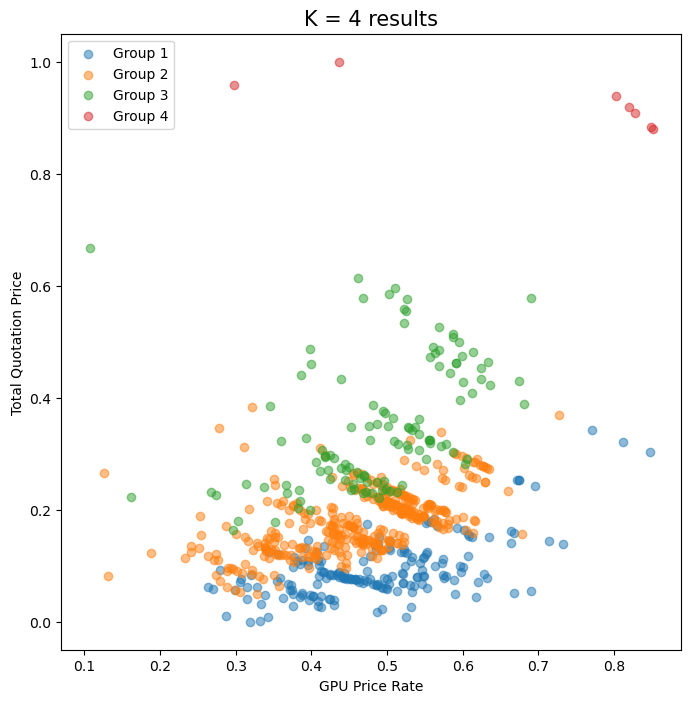

In [502]:
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(price_rate[res == i, 1], pdata[res == i, 3], alpha=0.5, label=f'Group {i+1}')

plt.title('K = %d results'%k , size = 15)
plt.legend()
plt.xlabel('GPU Price Rate')
plt.ylabel('Total Quotation Price')
plt.show()

# 3. 총 견적 가격(y축)에서 RAM이 차지하는 비율(x축)
- 전체적으로 총 견적 가격이 높을수록 RAM의 가격이 차지하는 비율은 낮아짐
- 그룹1 (파랑)

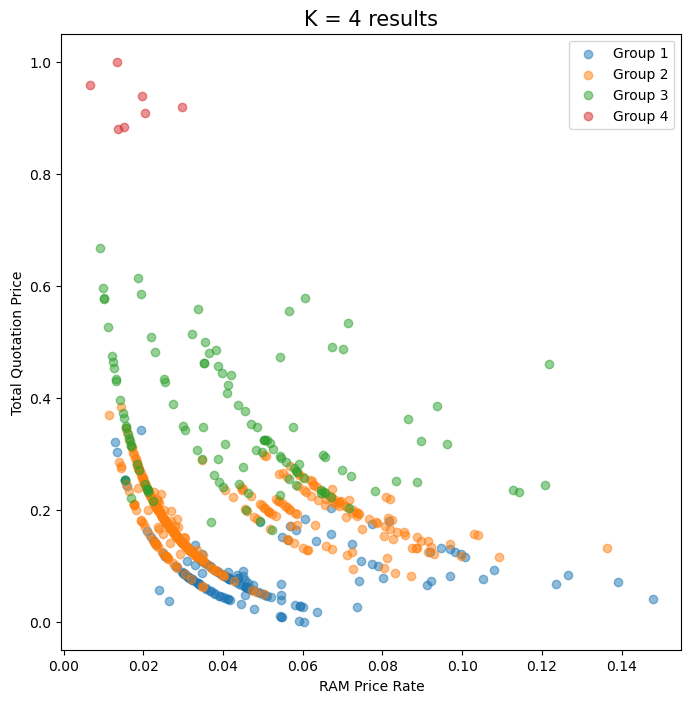

In [503]:
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(price_rate[res == i, 2], pdata[res == i, 3], alpha=0.5, label=f'Group {i+1}')

plt.title('K = %d results'%k , size = 15)
plt.legend()
plt.xlabel('RAM Price Rate')
plt.ylabel('Total Quotation Price')
plt.show()